In [1]:
# mike babb
# 2024 06 28
# what streets start and stop?

In [2]:
# standard
import os

In [56]:
# external
from itertools import combinations, product
import geopandas as gpd
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from shapely.geometry import LineString, Point
from shapely import line_merge

In [4]:
# custom
from geodataio.geo_operations import points2distance, calculate_initial_compass_bearing

# load the street network

In [5]:
# file path
input_file_path = 'H:/project/seattle_streets/data/' 
output_file_path = 'H:/project/seattle_streets/data/individual_streets'

In [55]:
file_name = 'Street_Network_Database.gpkg'

In [7]:
fpn = os.path.join(input_file_path, file_name)

In [8]:
gdf = gpd.read_file(filename = fpn)

In [9]:
gdf.columns

Index(['f_intr_id', 't_intr_id', 'snd_id', 'snd_feacod', 'citycode',
       'stname_id', 'st_code', 'arterial_c', 'segment_ty', 'agency_cod',
       'access_cod', 'divided_co', 'structure_', 'legalloc_c', 'vehicle_us',
       'gis_seg_length', 'l_adrs_from', 'l_adrs_to', 'r_adrs_from',
       'r_adrs_to', 'ord_pre_dir', 'ord_street', 'ord_street_type',
       'ord_suf_dir', 'ord_stname', 'l_city', 'l_state', 'l_zip', 'r_city',
       'r_state', 'r_zip', 'sndseg_upd', 'compkey', 'comptype', 'unitid',
       'unitid2', 'city_portion', 'ord_st_type', 'ord_street_st_type',
       'snd_group', 'geometry'],
      dtype='object')

In [10]:
# load the node data
input_file_name = 'Street_Network_Nodes.gpkg'

In [11]:
fpn = os.path.join(input_file_path, input_file_name)

In [12]:
node_gdf = gpd.read_file(filename = fpn)

In [13]:
node_gdf.head()

,node_id,geometry
0,13827,POINT (-122.40808 47.57771)
1,8721,POINT (-122.33029 47.65195)
2,3606,POINT (-122.28808 47.70834)
3,3784,POINT (-122.27712 47.70534)
4,14373,POINT (-122.40387 47.57132)


In [14]:
node_gdf['coords'] = node_gdf['geometry'].map(lambda x: x.coords[0])

In [15]:
node_gdf.head()

,node_id,geometry,coords
0,13827,POINT (-122.40808 47.57771),"(-122.40807905399998, 47.577706970000065)"
1,8721,POINT (-122.33029 47.65195),"(-122.33029050099998, 47.651945700000056)"
2,3606,POINT (-122.28808 47.70834),"(-122.28808025199999, 47.70834198600005)"
3,3784,POINT (-122.27712 47.70534),"(-122.27712366699996, 47.70533646400003)"
4,14373,POINT (-122.40387 47.57132),"(-122.40386783599996, 47.57132209200006)"


In [16]:
# zap this into a dictionary
node_dict = {}
for my_row in node_gdf.itertuples():
    node_dict[my_row.node_id] = my_row.coords

In [17]:
node_dict[10272]

(-122.39426507399997, 47.63229296900005)

# PASS 1: FOCUS ON JUST THE STREETS, REGARDLESS OF DIRECTION AND TYPE

In [18]:
gdf_agg = gdf[['ord_stname', 'snd_group']].drop_duplicates().groupby(['ord_stname']).agg( snd_group_count = ('snd_group', 'size')).reset_index()

In [19]:
gdf_agg.head()

,ord_stname,snd_group_count
0,10TH AVE,4
1,10TH AVE E,4
2,10TH AVE NE,2
3,10TH AVE NW,5
4,10TH AVE S,8


In [20]:
gdf_agg['snd_group_count'].describe()

count    2510.000000
mean        2.443028
std         2.353508
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max        15.000000
Name: snd_group_count, dtype: float64

In [21]:
# what are the streets with the most breaks?
gdf_agg.loc[gdf_agg['snd_group_count'] == gdf_agg['snd_group_count'].max(), :]

,ord_stname,snd_group_count
92,1ST AVE NW,15
203,30TH AVE S,15
253,35TH AVE S,15
2408,W RAYE ST,15


In [22]:
# number of streets with at least two segments
gdf_agg.loc[gdf_agg['snd_group_count'] > 1, :].shape

(1131, 2)

In [23]:
1131 / gdf_agg.shape[0]

0.450597609561753

In [24]:
gdf_agg.loc[gdf_agg['snd_group_count'] == 1, :].shape

(1379, 2)

In [25]:
1379 / gdf_agg.shape[0]

0.549402390438247

In [26]:
# 55 percent of streets are single segment
# 45 percent of streets are multi-segments.
# TODO: figure out how much of this is road miles.

In [27]:
# get start and end points of each line
#gdf['s_coord'] = gdf['geometry'].map(lambda x: x.coords[0])
#gdf['e_coord'] = gdf['geometry'].map(lambda x: x.coords[-1])

# BUILD THE ANTI-GRAPH OF DISCONNECTED SEGMENTS

In [28]:
def write_gdf(gdf: gpd.GeoDataFrame, output_file_path:str, output_file_name:str):
    
    ofpn = os.path.join(output_file_path, output_file_name)

    if 'coords' in gdf.columns:
        output_gdf = gdf.drop(labels = ['coords'], axis = 1)
        output_gdf.to_file(filename = ofpn, driver = 'GPKG', index = False)
    else:
        gdf.to_file(filename = ofpn, driver = 'GPKG', index = False)

    return None

In [29]:
def subset_node_gdf(node_gdf:gpd.GeoDataFrame, other_node_df:pd.DataFrame):
    node_subset_gdf = pd.merge(left = node_gdf, right = other_node_df)
    return node_subset_gdf

In [30]:
def create_graph_count_edges(gdf:gpd.GeoDataFrame, source_node:str, end_node:str):

    # create the graph for a single segment
    g = nx.from_pandas_edgelist(df = gdf, source = 'f_intr_id', target = 't_intr_id', edge_attr=True)
    node_list = list(g.nodes)

    # node distance, total hops, and number of edges per node
    node_dist_dict = {nn:0 for nn in node_list}
    node_hop_dict = {nn:0 for nn in node_list}
    # this will get the number of connected edges
    nn_edge_count_dict = {}
    
    # the snd of each node
    node_snd_group_dict = {}    
    snd_group_list = gdf['snd_group'].unique().tolist()
    for snd_group in snd_group_list:
        # use graph travesal to accumulate geographic distance
        curr_node_df = gdf.loc[gdf['snd_group'] == snd_group, ['f_intr_id', 't_intr_id']]
        curr_node_list = set(curr_node_df['f_intr_id'].tolist()).union(curr_node_df['t_intr_id'])                
        
        curr_node_snd_group_dict = {nn:snd_group for nn in curr_node_list}
        
        # combine the two dictionaries
        node_snd_group_dict = node_snd_group_dict | curr_node_snd_group_dict        
        
        # this will get the geographic distance and number of hops
        for sn, en in combinations(curr_node_list, r = 2):
            #print(sn, en)
            sp = nx.shortest_path(G = g, source = sn, target = en, weight = 'gis_seg_length')
            curr_dist = 0
            curr_hop_dist = 0        
            for i_nn, nn in enumerate(sp[:-1]):
                curr_dist += g[nn][sp[i_nn + 1]]['gis_seg_length']
                curr_hop_dist += 1            
            node_dist_dict[sn] += curr_dist
            node_dist_dict[en] += curr_dist
    
            node_hop_dict[sn] += curr_hop_dist
            node_hop_dict[en] += curr_hop_dist                
        
    for nn in node_list:
        nn_edge_count_dict[nn] = len(list(nx.dfs_edges(G = g, source=nn, depth_limit= 1)))
        
        
    # this gets the total geographic distance and total hops
    node_dist_df = pd.DataFrame.from_dict(data = node_dist_dict, orient = 'index', columns = ['tot_dist']).reset_index(names = ['node_id'])
    node_dist_df['tot_hop_dist'] = node_dist_df['node_id'].map(node_hop_dict)
    # number of edges
    node_dist_df['n_edges'] = node_dist_df['node_id'].map(nn_edge_count_dict)
    # add the snd_group
    node_dist_df['snd_group'] = node_dist_df['node_id'].map(node_snd_group_dict)        

    node_dist_df['avg_dist_per_hop'] = node_dist_df['tot_dist'] / node_dist_df['tot_hop_dist']
    # rank it!
    # greater distance indicates nodes further away from others
    node_dist_df['tot_dist_rank'] = node_dist_df.groupby(['snd_group'])['tot_dist'].rank(method = 'dense', ascending = False) 
    node_dist_df['tot_hop_dist_rank'] = node_dist_df.groupby(['snd_group'])['tot_hop_dist'].rank(method = 'dense', ascending = False)    
    # fewer edges indicates start and stop points
    node_dist_df['n_edges_rank'] = node_dist_df.groupby(['snd_group'])['n_edges'].rank(method = 'dense', ascending = True)
    # the rank per average distance - this also indicates greater distance
    node_dist_df['avg_dist_per_hop_rank'] = node_dist_df.groupby(['snd_group'])['avg_dist_per_hop'].rank(method = 'dense', ascending = True)
        
    # the nodes with the lowest combined ranks are the "start" and "end" points of the lines
    node_dist_df['combined_rank'] = node_dist_df['tot_dist_rank'] + node_dist_df['tot_hop_dist_rank'] + node_dist_df['n_edges_rank'] + node_dist_df['avg_dist_per_hop_rank']
    
    node_dist_df['final_rank'] = node_dist_df.groupby(['snd_group'])['combined_rank'].rank(method = 'dense', ascending = True)
    node_dist_df = node_dist_df.sort_values(by = ['snd_group', 'final_rank'], ascending = True)

    # build a dataframe that counts the number of edges per node:
    n_edge_count_df = node_dist_df.loc[node_dist_df['final_rank'] <= 2, :].copy()
    #print(n_edge_count_df.shape)

    node_snd_group_id_df = pd.DataFrame.from_dict(data = node_snd_group_dict, orient = 'index', columns = ['snd_group']).reset_index(names = ['node_id'])            
        
    #print(edge_count_df.head())
    #print(edge_count_df['snd_group'].value_counts())
    # update the dataframes of interest    
    #n_edge_count_df = n_edge_count_df.loc[-n_edge_count_df['node_id'].isin(drop_node_list), :].copy()
    
    snd_group_node_dict = {}
    snd_group_id_list = n_edge_count_df['snd_group'].unique().tolist()
    for snd_group in snd_group_id_list:        
        snd_group_node_dict[snd_group] = n_edge_count_df.loc[n_edge_count_df['snd_group'] == snd_group, 'node_id'].tolist()        

    
    return g, n_edge_count_df, node_dist_df, node_snd_group_id_df, node_snd_group_dict, snd_group_node_dict

In [31]:
sn = '10TH AVE E'

In [32]:
temp_gdf = gdf.loc[gdf['ord_stname'] == sn, :].copy()        

In [33]:
g, n_edge_count_df, node_dist_df, node_snd_group_id_df, node_snd_group_dict, snd_group_node_dict = create_graph_count_edges(gdf = temp_gdf, 
                                                                                                                  source_node = 'f_intr_id', 
                                                                                                                  end_node = 't_intr_id')


In [34]:
# nope, we can use k-edge augmentation with the computed distances to figure this out
# https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.connectivity.edge_augmentation.k_edge_augmentation.html#networkx.algorithms.connectivity.edge_augmentation.k_edge_augmentation

In [35]:
s_names = gdf_agg.loc[gdf_agg['snd_group_count'] > 1, 'ord_stname'].unique().tolist()
#s_names = ['13TH AVE W']

In [36]:
did_it_work = False
output_gdf_list = []
# extra explode gdf
ex_gdf_list = []
ex_ex_gdf_list = []
for sn in s_names[:None]:
    # get a street by name
    print(sn)
    # subset the gdf
    temp_gdf = gdf.loc[gdf['ord_stname'] == sn, :].copy()        
    
    # build a graph to find (dis)connected components: this is an easy way to find portions of a street that are not connected to each other
    # do I need this graph?
    
    # we can do products of products to find which streets should be compared.
    # the first product to compare is the street group ids
        
    snd_group_id_list = temp_gdf['snd_group'].unique()
    #print(snd_group_id_list)
    output_file_name = '_'.join(sn.split()) + '.gpkg'
    write_gdf(gdf = temp_gdf, output_file_path = output_file_path, output_file_name = output_file_name)
    
    # hmmm, let's compute the combinations
    # figure out which nodes in a graph only have one successor
    g, n_edge_count_df, node_dist_df, node_snd_group_id_df, node_snd_group_dict, snd_group_node_dict = create_graph_count_edges(gdf = temp_gdf, 
                                                                                                                   source_node = 'f_intr_id', 
                                                                                                                   end_node = 't_intr_id')
    # create a full graph of the street segment. 
    temp_gdf['weight'] = temp_gdf['gis_seg_length']
    fg = nx.from_pandas_edgelist(df = temp_gdf, source = 'f_intr_id', target = 't_intr_id', edge_attr=True)
    #n_edge_count_df = n_edge_count_df.loc[n_edge_count_df['tot_dist_rank'] <= 2, :]
    

    # subset of nodes - these are the furthest nodes.
    node_subset_gdf = subset_node_gdf(node_gdf = node_gdf, other_node_df = n_edge_count_df)
    output_file_name = 'subset_nodes_' + '_'.join(sn.split()) + '.gpkg'
    write_gdf(gdf = node_subset_gdf, output_file_path = output_file_path, output_file_name = output_file_name)

    # full nodes - all nodes in the line segments. 
    curr_node_df = pd.DataFrame(data = {'node_id':g.nodes()})
    node_subset_gdf = subset_node_gdf(node_gdf = node_gdf, other_node_df = curr_node_df)
    output_file_name = 'full_nodes_' + '_'.join(sn.split()) + '.gpkg'
    write_gdf(gdf = node_subset_gdf, output_file_path = output_file_path, output_file_name = output_file_name)
             
    # edge_list = []
    # for snd_group in n_edge_count_df['snd_group'].unique().tolist():
    #     nodes = n_edge_count_df.loc[n_edge_count_df['snd_group']==snd_group, 'node_id'].tolist()
    #     weight = points2distance(node_dict[nodes[0]], node_dict[nodes[1]], unit = 'miles')
    #     nodes.append(weight)
    #     edge_list.append(nodes)
    
    # create a list of available metrics
    avail_edges = []
    node_dist_dict = {}
    for ne in nx.non_edges(fg):    
        if node_snd_group_dict[ne[0]] != node_snd_group_dict[ne[1]]:
            # convert to feet to match
            weight = points2distance(node_dict[ne[0]], node_dict[ne[1]], unit = 'miles') * 5280
            output = (ne[0], ne[1], {'weight':weight})
            node_dist_dict[(ne[0], ne[1])] = weight 
            node_dist_dict[(ne[1], ne[0])] = weight 
            avail_edges.append(output)

    # this is missing segments.
    data_list = []
    line_list = []
    augmented_edges = nx.k_edge_augmentation(G = fg, k = 1, avail = avail_edges, weight = 'weight')    
    for i_ne, ne in enumerate(augmented_edges):
        weight = node_dist_dict[(ne[0], ne[1])] 
        temp_data_list = [sn, i_ne, ne[0], ne[1], weight]
        temp_line = LineString([node_dict[ne[0]], node_dict[ne[1]]])
        line_list.append(temp_line)
        data_list.append(temp_data_list)

    my_output_gdf = gpd.GeoDataFrame(data = data_list,
                                     columns = ['ord_stname', 'snd_group', 'sn_id', 'en_id', 'dist'],
                                     geometry = line_list, crs = 'epsg:4326')
    my_output_gdf['same_snd_group'] = int(0)

    col_names = ['ord_stname', 'snd_group', 'f_intr_id', 't_intr_id', 'gis_seg_length', 'geometry']    
    output_gdf = temp_gdf[col_names].copy()
    output_gdf['same_snd_group'] = int(1)
    output_gdf = output_gdf.rename(columns = {'f_intr_id':'sn_id', 't_intr_id':'en_id', 'gis_seg_length':'dist'})
    
    my_output_gdf = pd.concat([output_gdf, my_output_gdf])
    #print(my_output_gdf.head())
    
    
    #my_output_gdf.loc[my_output_gdf['sn_snd_group_id'] == my_output_gdf['en_snd_group_id'], 'same_snd_group'] = 1 
    #print(my_output_gdf.head())
    
    
    output_file_name = 'missing_segments_' + '_'.join(sn.split()) + '.gpkg'
    ofpn = os.path.join(output_file_path, output_file_name)    
    
    my_output_gdf.to_file(filename = ofpn, driver = 'GPKG', index = False)

    output_gdf_list.append(my_output_gdf)
    did_it_work = True

10TH AVE
10TH AVE E
10TH AVE NE
10TH AVE NW
10TH AVE S
10TH AVE SW
10TH AVE W
10TH PL NE
11TH AVE E
11TH AVE NE
11TH AVE NW
11TH AVE S
11TH AVE SW
11TH AVE W
12TH AVE E
12TH AVE NE
12TH AVE NW
12TH AVE S
12TH AVE SW
12TH AVE W
13TH AVE
13TH AVE E
13TH AVE NW
13TH AVE S
13TH AVE SW
13TH AVE W
14TH AVE E
14TH AVE NE
14TH AVE NW
14TH AVE S
14TH AVE SW
14TH AVE W
15TH AVE E
15TH AVE NE
15TH AVE S
15TH AVE SW
15TH AVE W
15TH PL S
16TH AVE
16TH AVE E
16TH AVE NE
16TH AVE S
16TH AVE SW
16TH AVE W
17TH AVE
17TH AVE E
17TH AVE NE
17TH AVE NW
17TH AVE S
17TH AVE SW
18TH AVE E
18TH AVE NE
18TH AVE NW
18TH AVE S
18TH AVE SW
19TH AVE E
19TH AVE NE
19TH AVE NW
19TH AVE S
19TH AVE SW
1ST AVE N
1ST AVE NE
1ST AVE NW
1ST AVE S
1ST AVE SW
1ST AVE W
20TH AVE E
20TH AVE NE
20TH AVE NW
20TH AVE S
20TH AVE SW
20TH AVE W
20TH PL S
21ST AVE E
21ST AVE NE
21ST AVE NW
21ST AVE S
21ST AVE SW
21ST AVE W
22ND AVE E
22ND AVE NE
22ND AVE NW
22ND AVE S
22ND AVE SW
22ND AVE W
22ND PL NE
23RD AVE E
23RD AVE NE
23RD AVE

C:\Users\babbm\AppData\Local\Temp\ipykernel_21700\3843645745.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  my_output_gdf = pd.concat([output_gdf, my_output_gdf])


E CALHOUN ST
E COLUMBIA ST
E CROCKETT ST
E DENNY WAY
E EDGAR ST
E FIR ST
E GALER ST
E GARFIELD ST
E HAMLIN ST
E HARRISON ST
E HIGHLAND DR
E HOWE ST
E HOWELL ST
E JAMES ST
E JEFFERSON ST
E JOHN ST
E LEE ST
E LOUISA ST
E LYNN ST
E MARION ST
E MARTIN ST
E MCGRAW ST
E MERCER ST
E MILLER ST
E NEWTON ST
E OLIVE ST
E PIKE ST
E PINE ST
E PROSPECT ST
E REPUBLICAN ST
E ROANOKE ST
E ROY ST
E SHELBY ST
E SPRING ST
E SPRUCE ST
E TERRACE ST
E THOMAS ST
E VALLEY ST
E WARD ST
E YESLER WAY
EARL AVE NW
EASTERN AVE N
EASTLAKE AVE E
EDGEWOOD AVE SW
ELLIOTT AVE
ELLIOTT AVE W
EUCLID AVE
EVANSTON AVE N
EVERETT AVE E
EXETER AVE NE
FAIRVIEW AVE E
FARWELL PL SW
FAUNTLEROY AVE SW
FAUNTLEROY WAY SW
FERRY AVE SW
FOREST AVE S
FRANCIS AVE N
FRANKLIN AVE E
FREMONT AVE N
FREMONT LN N
FUHRMAN AVE E
FULTON ST
GALER ST
GARDEN PL S
GARFIELD ST
GARLOUGH AVE SW
GAY AVE W
GILMAN AVE W
GREENWOOD AVE N
HALLADAY ST
HAMPTON RD S
HARRIS PL S
HARRISON ST
HARVARD AVE E
HAYES ST
HIGHLAND DR
HILLCREST AVE SW
HIRAM PL NE
HOBART AVE SW

C:\Users\babbm\AppData\Local\Temp\ipykernel_21700\3843645745.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  my_output_gdf = pd.concat([output_gdf, my_output_gdf])


MIDVALE AVE N
MILITARY RD S
MINOR AVE
MINOR AVE N
MONTAVISTA PL W
MORSE AVE S
N 103RD ST
N 105TH ST
N 107TH ST
N 110TH ST
N 112TH ST
N 115TH ST
N 117TH ST
N 120TH ST
N 122ND ST
N 127TH ST
N 132ND ST
N 133RD ST
N 134TH ST
N 135TH ST
N 136TH ST
N 137TH ST
N 138TH ST
N 140TH ST
N 141ST ST
N 143RD ST
N 38TH ST
N 39TH ST
N 40TH ST
N 41ST ST
N 42ND ST
N 43RD ST
N 44TH ST
N 45TH ST
N 46TH ST
N 47TH ST
N 50TH ST
N 51ST ST
N 52ND ST
N 53RD ST
N 54TH ST
N 55TH ST
N 56TH ST
N 57TH ST
N 58TH ST
N 59TH ST
N 60TH ST
N 61ST ST
N 62ND ST
N 63RD ST
N 64TH ST
N 65TH ST
N 66TH ST
N 67TH ST
N 72ND ST
N 75TH ST
N 77TH ST
N 78TH ST
N 79TH ST
N 82ND ST
N 85TH ST
N 86TH ST
N 87TH ST
N 88TH ST
N 89TH ST
N 90TH ST
N 92ND ST
N 94TH ST
N 95TH ST
N 96TH ST
N 97TH ST
N ALLEN PL
N BOWDOIN PL
N NORTHLAKE PL
NE 100TH ST
NE 102ND ST
NE 103RD ST
NE 104TH ST
NE 105TH PL
NE 105TH ST
NE 106TH ST
NE 107TH ST
NE 108TH ST
NE 109TH ST
NE 112TH ST
NE 113TH ST
NE 114TH ST
NE 117TH ST
NE 120TH ST
NE 122ND ST
NE 123RD ST
NE 124TH 

C:\Users\babbm\AppData\Local\Temp\ipykernel_21700\3843645745.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  my_output_gdf = pd.concat([output_gdf, my_output_gdf])


NEWELL ST
NEWTON ST
NOB HILL AVE N
NORTH PARK AVE N
NW 100TH ST
NW 101ST ST
NW 103RD ST
NW 105TH ST
NW 106TH ST
NW 107TH ST
NW 115TH ST
NW 116TH ST
NW 117TH ST
NW 118TH ST
NW 120TH ST
NW 122ND ST
NW 130TH ST
NW 40TH ST
NW 41ST ST
NW 43RD ST
NW 44TH ST
NW 46TH ST
NW 47TH ST
NW 48TH ST
NW 49TH ST
NW 50TH ST
NW 51ST ST
NW 52ND ST
NW 53RD ST
NW 54TH ST
NW 56TH ST
NW 58TH ST
NW 59TH ST
NW 61ST ST
NW 62ND ST
NW 64TH ST
NW 65TH ST
NW 66TH ST
NW 67TH ST
NW 68TH ST
NW 70TH ST
NW 72ND ST
NW 73RD ST
NW 74TH ST
NW 77TH ST
NW 83RD ST
NW 86TH ST
NW 87TH ST
NW 88TH ST
NW 89TH ST
NW 90TH PL
NW 90TH ST
NW 91ST ST
NW 92ND ST
NW 93RD ST
NW 94TH ST
NW 95TH ST
NW 96TH ST
NW 97TH ST
NW 98TH ST
NW 99TH ST
NW BALLARD WAY
NW BOWDOIN PL
NW MARKET ST
OCCIDENTAL AVE S
OHIO AVE S
OSWEGO PL NE
PALATINE AVE N
PASADENA PL NE
PERKINS LN W
PHINNEY AVE N
PIKE ST
PINE ST
PONTIUS AVE N
PORTAGE BAY PL E
POST AVE
PRINCETON AVE NE
PROSPECT ST
PUGET BLVD SW
QUEEN ANNE AVE N
RAILROAD WAY S
RAINIER AVE S
RAINIER VISTA NE
RANDOL

C:\Users\babbm\AppData\Local\Temp\ipykernel_21700\3843645745.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  my_output_gdf = pd.concat([output_gdf, my_output_gdf])


SHAFFER AVE S
SHINKLE PL SW
SMITH ST
SPOKANE TURN RD
STONE AVE N
STROUD AVE N
STURGUS AVE S
SUMMIT AVE
SUMMIT AVE E
SUNNYSIDE AVE N
SW 100TH ST
SW 102ND ST
SW 103RD ST
SW 104TH ST
SW 105TH ST
SW 106TH ST
SW 107TH ST
SW 108TH ST
SW 109TH ST
SW 110TH LN
SW 110TH ST
SW 111TH PL
SW 111TH ST
SW 112TH ST
SW 113TH ST
SW 114TH ST
SW 97TH PL
SW 97TH ST
SW 98TH ST
SW 99TH ST
SW ADAMS ST
SW ALASKA ST
SW ANDOVER ST
SW AUSTIN ST
SW BARTON ST
SW BRADFORD ST
SW BRANDON ST
SW CAMBRIDGE ST
SW CANADA DR
SW CHARLESTOWN ST
SW CITY VIEW ST
SW CLOVERDALE ST
SW COLLEGE ST
SW CONCORD ST
SW DAKOTA ST
SW DAWSON ST
SW DIRECTOR ST
SW DONOVAN ST
SW EDDY ST
SW EDMUNDS ST
SW ELMGROVE ST
SW FINDLAY ST
SW FLETCHER ST
SW FLORIDA ST
SW FONTANELLE ST
SW FOREST ST
SW GENESEE ST
SW GRAHAM ST
SW GRAYSON ST
SW HANFORD ST
SW HENDERSON ST
SW HILL ST
SW HINDS ST
SW HOLDEN ST
SW HOLGATE ST
SW HOLLY ST
SW HORTON ST
SW HUDSON ST
SW JUNEAU ST
SW KENYON ST
SW KLICKITAT WAY
SW LANDER ST
SW MANNING ST
SW MARGUERITE CT
SW MASSACHUSETTS

C:\Users\babbm\AppData\Local\Temp\ipykernel_21700\3843645745.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  my_output_gdf = pd.concat([output_gdf, my_output_gdf])


W LAWTON ST
W LEE ST
W LYNN PL
W LYNN ST
W MANSELL ST
W MARINA PL
W MCGRAW PL
W MCGRAW ST
W NEWELL ST
W NEWTON ST
W NICKERSON ST
W PARKMONT PL
W PLEASANT PL
W PROSPECT ST
W RAYE ST
W ROY ST
W RUFFNER ST
W SEMPLE ST
W SHERIDAN ST
W SMITH ST
W THOMAS ST
W THURMAN ST
W TILDEN ST
W WHEELER ST
WALLA WALLA RD NE
WALLINGFORD AVE N
WALNUT AVE SW
WARD ST
WARREN AVE N
WASHINGTON AVE
WASHINGTON AVE W
WAYNE PL N
WELLINGTON AVE
WESTLAKE AVE
WESTLAKE AVE N
WESTWOOD PL NE
WETMORE AVE S
WHEELER ST
WHITMAN AVE N
WINSLOW PL N
WOLCOTT AVE S
WOODLAND PARK AVE N
WOODLAWN AVE N
YAKIMA AVE S
YALE AVE
YALE AVE N


In [88]:
ms_gdf = pd.concat(objs = output_gdf_list)

In [89]:
ms_gdf['dist_miles'] = ms_gdf['dist'] / 5280

In [90]:
output_file_path = 'H:/project/seattle_streets/data'
output_file_name = 'missing_segments.gpkg'
ofpn = os.path.join(output_file_path, output_file_name)    

ms_gdf.to_file(filename = ofpn, driver = 'GPKG', index = False)

In [91]:
did_it_work

True

In [92]:
# find the longest
ms_gdf['same_snd_group'].value_counts()

same_snd_group
1    21181
0     3611
Name: count, dtype: int64

In [93]:
ms_gdf.shape

(24792, 8)

In [94]:
gdf['ord_stname'].unique().shape

(2510,)

In [95]:
wms_gdf = ms_gdf.loc[ms_gdf['same_snd_group'] == 0, :].copy()

In [96]:
(wms_gdf['dist']).describe()

count     3611.000000
mean      1212.225533
std       2004.750316
min          3.928436
25%        173.950721
50%        447.043657
75%       1321.809023
max      26260.998994
Name: dist, dtype: float64

In [97]:
wms_gdf['dist_rank'] = wms_gdf['dist'].rank(method = 'dense', ascending = False)

In [98]:
wms_gdf.loc[wms_gdf['dist_rank'] <= 10, 'ord_stname'].tolist()

['11TH AVE S',
 '20TH AVE S',
 '33RD AVE SW',
 '7TH PL S',
 '9TH AVE S',
 'S 105TH ST',
 'S 106TH ST',
 'S 108TH ST',
 'S 112TH ST',
 'S 116TH ST']

In [99]:
temp_agg = ms_gdf[['ord_stname', 'same_snd_group']].drop_duplicates()

In [100]:
temp_agg.shape

(2257, 2)

In [101]:
wms_gdf.head()

,ord_stname,snd_group,sn_id,en_id,dist,geometry,same_snd_group,dist_miles,dist_rank
0,10TH AVE,0,12359,12339,135.408451,"LINESTRING (-122.31941 47.60310, -122.31934 47...",0,0.025646,2967.0
1,10TH AVE,1,12162,11978,1104.943768,"LINESTRING (-122.31942 47.60621, -122.31937 47...",0,0.209270,1035.0
2,10TH AVE,2,11906,11829,493.739007,"LINESTRING (-122.31936 47.61040, -122.31935 47...",0,0.093511,1733.0
0,10TH AVE E,0,9390,9391,113.275690,"LINESTRING (-122.32006 47.64319, -122.31960 47...",0,0.021454,3142.0
1,10TH AVE E,1,11178,11179,93.610169,"LINESTRING (-122.31994 47.62108, -122.31956 47...",0,0.017729,3267.0


In [110]:
wms_gdf['dist_miles_log'] = np.log10(wms_gdf['dist_miles'])

In [117]:
wms_gdf['dist_miles_log'].describe()

count    3611.000000
mean       -1.022903
std         0.578679
min        -3.128414
25%        -1.482208
50%        -1.072284
75%        -0.601465
max         0.696677
Name: dist_miles_log, dtype: float64

..\assets\dist_histogram.png


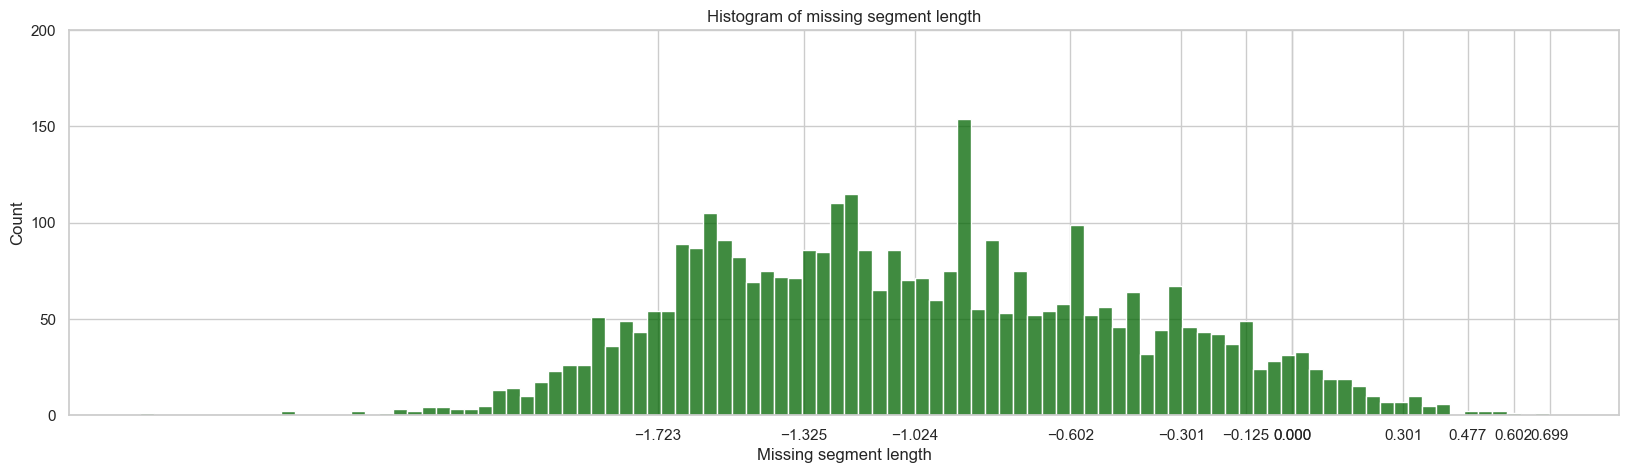

In [236]:
# let's make a graphic showing the distances
sns.set_theme(style = "whitegrid")
f, ax = plt.subplots(figsize = (20, 5))

my_plot = sns.histplot(data = wms_gdf, x = 'dist_miles_log',
                      color='darkgreen', bins = 100)

y_ticks = list(range(0, 201, 50))
y_tick_labels_formatted = ['{:,}'.format(ytl) for ytl in y_ticks]   

my_plot.set_yticks(ticks = y_ticks)
my_plot.set_yticklabels(labels = y_tick_labels_formatted, rotation=0)

plt.title(label = "Histogram of missing segment length")
plt.xlabel(xlabel = 'Missing segment length')
plt.ylabel(ylabel = "Count")

#x_ticks = list(range(-3,1))
x_ticks = np.log10(my_start_list)
#x_tick_labels_formatted = ['{:,}'.format(10**xtl) for xtl in x_ticks]   

my_plot.set_xticks(ticks = x_tick_list)
#my_plot.set_xticklabels(labels = x_tick_labels_formatted, rotation=0)

output_file_name = '..\\assets\\dist_histogram.png'
output_file_name = os.path.normpath(output_file_name)
print(output_file_name)
my_plot.get_figure().savefig(fname = output_file_name)

In [230]:
my_start_list = [100, 250, 500]

In [231]:
for ii in range(1, 5):
    my_calc = int((5280 * (ii / 4)))    
    my_start_list.append(my_calc)    

In [232]:
my_start_list

[100, 250, 500, 1320, 2640, 3960, 5280]

In [233]:
for ii in range(1, 2):
    for jj in range(0, 5):
        my_calc = int((5280 * (ii / 1)) + (5280 * jj))        
        my_start_list.append(my_calc)    

In [237]:
x_tick_list = [x for x in my_start_list]

In [238]:
x_tick_list

[100, 250, 500, 1320, 2640, 3960, 5280, 5280, 10560, 15840, 21120, 26400]